In [160]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
from sklearn.model_selection import KFold
from sklearn import datasets, linear_model, metrics 
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV

sns.set(font_scale=3)

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 2000)


In [161]:
start_time = calendar.timegm(datetime(2024, 4, 25, 0, 0, 0).timetuple())
end_time = calendar.timegm(datetime(2023, 4, 25, 0, 0, 0).timetuple())
url = f'https://query1.finance.yahoo.com/v7/finance/download/UPRO?period1={end_time}&period2={start_time}&interval=1d&events=history&includeAdjustedClose=true'

upro_data = pd.read_csv(url)

upro_data = upro_data.drop(columns=['High', 'Low', 'Adj Close', 'Volume'])

upro_data = upro_data.sort_values(by=['Date'], ascending=False)

In [165]:
upro_data['1_ago_close'] = upro_data['Close'].shift(-1)
upro_data['1_ago_close_percent'] = 1 - upro_data['Close'] / upro_data['1_ago_close']
upro_data['open_close_percent'] = upro_data['Close'] / upro_data['Open']

In [166]:
upro_data['open_close_percent'] = upro_data['Open'] / upro_data['Close']
upro_data['yesterday_close'] = upro_data['Close'].shift(-1)

percentage_columns = ['1_ago_close_percent']
days_back = 7
for x in range(2, days_back + 1):
    percentage_columns.append(f'{x}_ago_close_percent')
    upro_data[f'{x}_ago_close'] = upro_data['Close'].shift(x*-1)
    upro_data[f'{x}_ago_close_percent'] = 1 -  upro_data['yesterday_close'] / upro_data[f'{x}_ago_close']
upro_data.drop(upro_data.tail(days_back).index,inplace=True)

## Summary

My dependent or taget variable should be 'Close' on a given date. I could convert that to a percentage gain from previous close by using `1_ago_close_percent`.

I am not sure if I will have the current `open` value when making market decisions, so I might want to remove that as a independent variable / feature.


In [167]:
upro_data.head()

,Date,Open,Close,1_ago_close,1_ago_close_percent,open_close_percent,yesterday_close,2_ago_close,2_ago_close_percent,3_ago_close,3_ago_close_percent,4_ago_close,4_ago_close_percent,5_ago_close,5_ago_close_percent,6_ago_close,6_ago_close_percent,7_ago_close,7_ago_close_percent
251,2024-04-24,63.290001,62.880001,62.930000,0.000795,1.006520,62.930000,60.750000,-0.035885,59.160000,-0.063725,60.779999,-0.035373,61.259998,-0.027261,62.369999,-0.008979,62.770000,-0.002549
250,2024-04-23,61.560001,62.930000,60.750000,-0.035885,0.978230,60.750000,59.160000,-0.026876,60.779999,0.000494,61.259998,0.008325,62.369999,0.025974,62.770000,0.032181,65.199997,0.068251
249,2024-04-22,60.150002,60.750000,59.160000,-0.026876,0.990123,59.160000,60.779999,0.026653,61.259998,0.034280,62.369999,0.051467,62.770000,0.057512,65.199997,0.092638,68.099998,0.131278
248,2024-04-19,60.759998,59.160000,60.779999,0.026653,1.027045,60.779999,61.259998,0.007835,62.369999,0.025493,62.770000,0.031703,65.199997,0.067791,68.099998,0.107489,66.680000,0.088482
247,2024-04-18,61.730000,60.779999,61.259998,0.007835,1.015630,61.259998,62.369999,0.017797,62.770000,0.024056,65.199997,0.060429,68.099998,0.100441,66.680000,0.081284,68.699997,0.108297


In [168]:
upro_data.describe()

,Open,Close,1_ago_close,1_ago_close_percent,open_close_percent,yesterday_close,2_ago_close,2_ago_close_percent,3_ago_close,3_ago_close_percent,4_ago_close,4_ago_close_percent,5_ago_close,5_ago_close_percent,6_ago_close,6_ago_close_percent,7_ago_close,7_ago_close_percent
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,51.242899,51.275462,51.172941,-0.002300,0.999365,51.172941,51.070840,-0.002287,50.978865,-0.004440,50.891386,-0.006513,50.799328,-0.008652,50.705042,-0.010864,50.597731,-0.013376
std,9.289638,9.235301,9.241365,0.021724,0.018205,9.241365,9.245158,0.021727,9.257337,0.031864,9.278049,0.038786,9.288211,0.044828,9.295468,0.050749,9.307649,0.055851
min,36.700001,35.970001,35.970001,-0.061632,0.948798,35.970001,35.970001,-0.061632,35.970001,-0.089926,35.970001,-0.119198,35.970001,-0.149013,35.970001,-0.179872,35.970001,-0.187378
25%,44.135000,44.302499,44.284999,-0.017812,0.988370,44.284999,44.115001,-0.017812,43.954999,-0.025892,43.860000,-0.033252,43.637500,-0.038731,43.434999,-0.045843,43.359998,-0.045877
50%,48.330000,48.365002,48.325001,-0.001632,0.997679,48.325001,48.299999,-0.001632,48.229999,-0.005848,48.135000,-0.009591,48.085001,-0.007388,48.075001,-0.010557,48.070000,-0.018822
75%,58.512501,58.727500,58.539999,0.010436,1.008754,58.539999,58.190001,0.010436,57.640000,0.017225,57.402500,0.021362,56.969999,0.017617,56.705000,0.020537,56.280001,0.021195
max,70.879997,70.589996,70.589996,0.049855,1.064999,70.589996,70.589996,0.049855,70.589996,0.078768,70.589996,0.101730,70.589996,0.106113,70.589996,0.116057,70.589996,0.131278


<AxesSubplot:xlabel='Date', ylabel='1_ago_close_percent'>

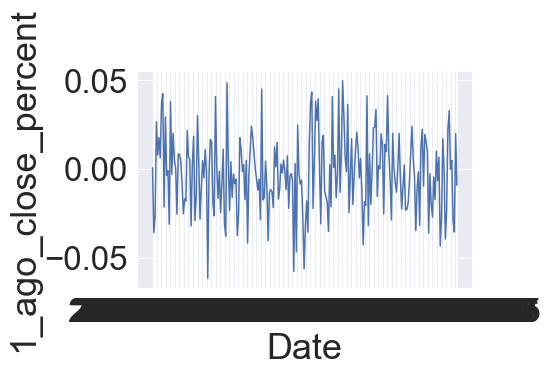

In [169]:
sns.lineplot(data=upro_data, x="Date", y="1_ago_close_percent")


In [170]:
np.sum(upro_data.isnull())

Date                   0
Open                   0
Close                  0
1_ago_close            0
1_ago_close_percent    0
open_close_percent     0
yesterday_close        0
2_ago_close            0
2_ago_close_percent    0
3_ago_close            0
3_ago_close_percent    0
4_ago_close            0
4_ago_close_percent    0
5_ago_close            0
5_ago_close_percent    0
6_ago_close            0
6_ago_close_percent    0
7_ago_close            0
7_ago_close_percent    0
dtype: int64

In [171]:
only_percent = upro_data[percentage_columns].copy()
only_percent.describe()

,1_ago_close_percent,2_ago_close_percent,3_ago_close_percent,4_ago_close_percent,5_ago_close_percent,6_ago_close_percent,7_ago_close_percent
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,-0.002300,-0.002287,-0.004440,-0.006513,-0.008652,-0.010864,-0.013376
std,0.021724,0.021727,0.031864,0.038786,0.044828,0.050749,0.055851
min,-0.061632,-0.061632,-0.089926,-0.119198,-0.149013,-0.179872,-0.187378
25%,-0.017812,-0.017812,-0.025892,-0.033252,-0.038731,-0.045843,-0.045877
50%,-0.001632,-0.001632,-0.005848,-0.009591,-0.007388,-0.010557,-0.018822
75%,0.010436,0.010436,0.017225,0.021362,0.017617,0.020537,0.021195
max,0.049855,0.049855,0.078768,0.101730,0.106113,0.116057,0.131278


<AxesSubplot:>

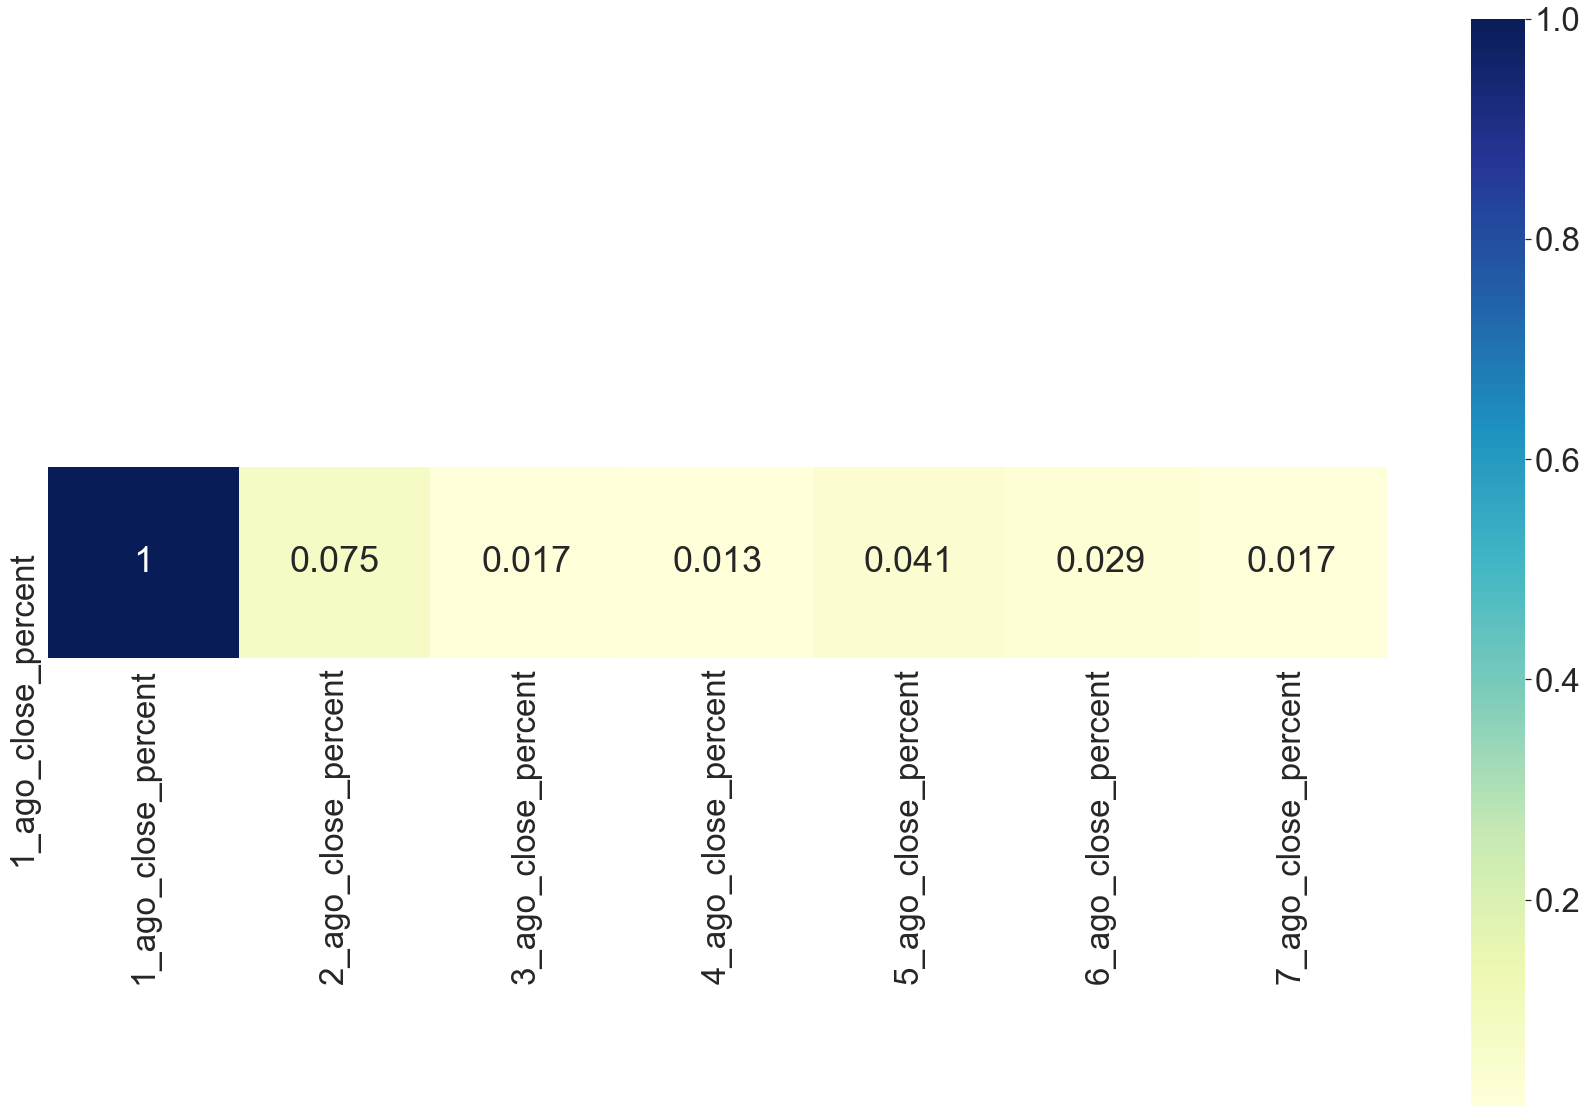

In [172]:
corr_mat = only_percent.corr(method='pearson')
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
sns.heatmap(corr_mat[['1_ago_close_percent']].transpose(), vmax=1, square=True, annot=True, cmap="YlGnBu")

## K-Folds Sample

In [173]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([6, 7, 8, 9])
kf = KFold(n_splits=2)
kf.get_n_splits(X)

2

In [174]:
print(kf)

KFold(n_splits=2, random_state=None, shuffle=False)


In [175]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


In [176]:
y_train

array([6, 7])

In [177]:
y_test

array([8, 9])

## K-Folds With our data

In [178]:
y = only_percent['1_ago_close_percent'].values
X = only_percent.drop(['1_ago_close_percent'], axis=1).values
# there might be a unique or scramble option i should use.
kf = KFold(n_splits=2)
kf.get_n_splits(X)

2

In [179]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [180]:
regression = RidgeCV(alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

In [181]:
y_pred

array([-0.0042196 , -0.00422203, -0.00423347, -0.00423644, -0.00423287,
       -0.00422823, -0.00423152, -0.0042322 , -0.00423043, -0.00422549,
       -0.00421538, -0.0042143 , -0.00421726, -0.00421227, -0.00420709,
       -0.00420922, -0.00421344, -0.00421575, -0.00422107, -0.00422123,
       -0.0042283 , -0.00422325, -0.00422114, -0.00422448, -0.00423329,
       -0.0042343 , -0.00422781, -0.00423474, -0.00423572, -0.00422557,
       -0.00422262, -0.00422253, -0.00422011, -0.00421456, -0.00422118,
       -0.00422275, -0.00421967, -0.00422375, -0.00422525, -0.00422054,
       -0.00421342, -0.00420954, -0.00421106, -0.00420847, -0.00420686,
       -0.00421423, -0.00421717, -0.00422165, -0.00421709, -0.0042246 ,
       -0.00422396, -0.00422734, -0.0042297 , -0.00422835, -0.00422592,
       -0.00421885, -0.0042211 , -0.00422394, -0.00422694, -0.00422558,
       -0.00422328, -0.00422657, -0.00422613, -0.00422683, -0.00421795,
       -0.00421406, -0.00421527, -0.00422178, -0.00421847, -0.00

In [182]:
from sklearn.linear_model import ElasticNet

In [183]:
regression = ElasticNet(alpha=1.0, l1_ratio=0.5)
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

In [184]:
y_pred

array([-0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00421578,
       -0.00421578, -0.00421578, -0.00421578, -0.00421578, -0.00